In [2]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import requests
import pathlib
from pathlib import Path
from tqdm.auto import tqdm

In [3]:
!pip install -q torchmetrics -q mlxtend

In [4]:
import torchmetrics,mlxtend
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

In [5]:
train_data = datasets.FashionMNIST(root='data',train=True,download=True,transform=ToTensor())
test_data = datasets.FashionMNIST(root='data',train=False,download=True,transform=ToTensor())

In [6]:
class_names=train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [7]:
train_dataloader = DataLoader(train_data,batch_size=32,shuffle=True)
test_dataloader = DataLoader(test_data,batch_size=32,shuffle=False)

In [8]:
request=requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py')
with open('helper_functions.py','wb') as f:
  f.write(request.content)

In [9]:
from helper_functions import accuracy_fn

In [10]:
device='cuda' if torch.cuda.is_available() else 'cpu'

In [11]:
def train_step(model:torch.nn.Module,loss_fn:torch.nn.Module,optimizer:torch.optim.Optimizer,dataloader:torch.utils.data.DataLoader,device:torch.device=device):
  train_loss,train_acc =0,0
  model.to(device)
  model.train()
  for batch,(X,y) in enumerate(dataloader):
    X,y = X.to(device),y.to(device)
    y_pred = model(X)
    loss= loss_fn(y_pred,y)
    optimizer.zero_grad()
    train_loss += loss.item()
    train_acc += accuracy_fn(y_pred=torch.softmax(y_pred,dim=1).argmax(dim=1),y_true=y)
    loss.backward()
    optimizer.step()
  train_loss /= len(dataloader)
  train_acc /= len(dataloader)
  return train_loss,train_acc

In [12]:
def test_step(model:torch.nn.Module,loss_fn:torch.nn.Module,dataloader:torch.utils.data.DataLoader,device:torch.device=device):
  test_loss,test_acc =0,0
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for batch,(X,y) in enumerate(dataloader):
      X,y = X.to(device),y.to(device)
      y_pred = model(X)
      loss= loss_fn(y_pred,y)

      test_loss += loss.item()
      test_acc += accuracy_fn(y_pred=y_pred.argmax(dim=1),y_true=y)

    test_loss /= len(dataloader)
    test_acc /= len(dataloader)
  return test_loss,test_acc

In [17]:
class ModelV2(torch.nn.Module):
  def __init__(self,input_dim:int,hidden_dim:int,output_dim:int):
    super().__init__()
    self.layer_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_dim,out_channels=hidden_dim,kernel_size=3,padding=1,stride=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_dim,out_channels=hidden_dim,kernel_size=3,padding=1,stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2)
    )
    self.layer_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_dim,out_channels=hidden_dim,kernel_size=3,padding=1,stride=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_dim,out_channels=hidden_dim,kernel_size=3,padding=1,stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_dim*7*7,out_features=output_dim)
    )

  def forward(self,x:torch.Tensor):
    x = self.layer_1(x)
    x = self.layer_2(x)
    x = self.classifier(x)
    return x

In [18]:
torch.manual_seed(32)
model = ModelV2(input_dim=1,hidden_dim=10,output_dim=len(class_names))
model

ModelV2(
  (layer_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [19]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),lr=0.01)

In [20]:
EPOCHS=5

for epoch in tqdm(range(1,EPOCHS+1)):
  train_loss,train_acc = train_step(model=model,loss_fn=loss_fn,optimizer=optimizer,dataloader=train_dataloader,device=device)
  test_loss,test_acc = test_step(model=model,loss_fn=loss_fn,dataloader=test_dataloader,device=device)
  print(f'train_loss:{train_loss:.3f} train_acc:{train_acc:.3f} test_loss:{test_loss:.3f} test_acc:{test_acc:.3f}')



  0%|          | 0/5 [00:00<?, ?it/s]

train_loss:0.454 train_acc:83.612 test_loss:0.409 test_acc:85.094
train_loss:0.362 train_acc:86.858 test_loss:0.382 test_acc:86.002
train_loss:0.351 train_acc:87.282 test_loss:0.374 test_acc:86.841
train_loss:0.340 train_acc:87.605 test_loss:0.363 test_acc:86.322
train_loss:0.345 train_acc:87.368 test_loss:0.369 test_acc:86.991


In [22]:
y_preds=[]
model.eval()
with torch.inference_mode():
  for X,y in tqdm(test_dataloader,desc='making predictions'):
    X,y = X.to(device),y.to(device)
    y_pred = model(X)
    y_pred = torch.softmax(y_pred,dim=1).argmax(dim=1)
    y_preds.append(y_pred.cpu())

y_preds = torch.concat(y_preds)

making predictions:   0%|          | 0/313 [00:00<?, ?it/s]

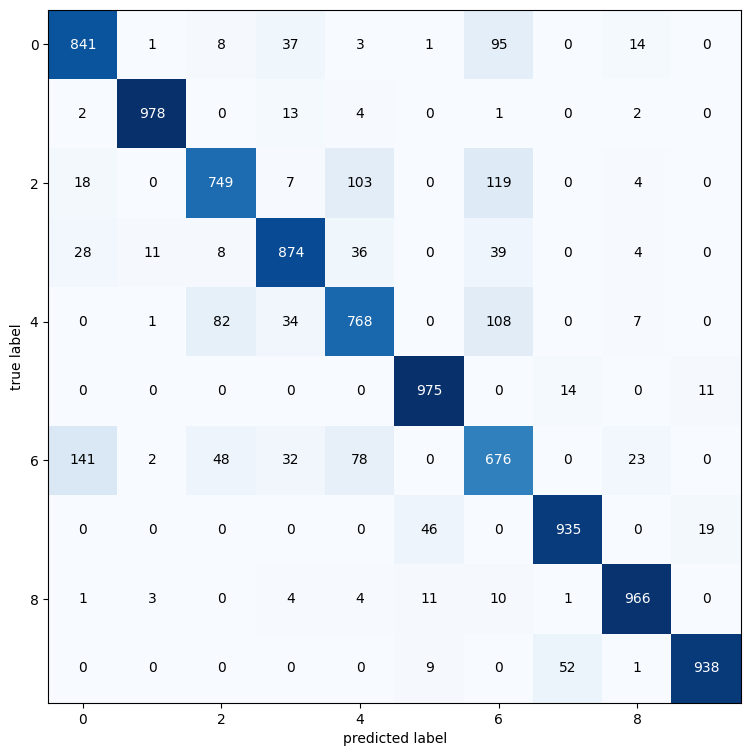

In [24]:
conf_matrix = ConfusionMatrix(num_classes=len(class_names),task='multiclass')
confusion_matrix = conf_matrix(preds=y_preds,target=test_data.targets)
fig,ax = plot_confusion_matrix(conf_mat=confusion_matrix.numpy(),figsize=(9,9))
plt.show()